# Hourly Temperature Forecasting
Trong bài tập này, chúng ta sẽ xây dựng một mô hình về Times Series dùng để dự đoán nhiệt độ trong 1 giờ tiếp theo dựa trên nhiệt độ của 6 giờ trước đó. Các bạn sẽ thực hiện theo hướng dẫn sau:

# 1.Import các thư viện cần thiết

In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

# 2.Tải bộ dữ liệu
Các bạn tải bộ dữ liệu tại đây. Dưới đây là thông tin 4 hàng đầu tiên của
bảng dữ liệu

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06/W03

/content/drive/MyDrive/Colab Notebooks/MODULE06/W03


In [ ]:
#https://drive.google.com/file/d/178YSDYmlRh54IcxStgYA3UyKFRM9-3DO/view
#!gdown --id 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

In [ ]:
# unzip dataset
#!unzip dataset.zip

# 3.Chuẩn bị dữ liệu

## (a) Đọc dữ liệu từ file .csv

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06/W03

/content/drive/MyDrive/Colab Notebooks/MODULE06/W03


In [4]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

In [5]:
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

In [ ]:
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [ ]:
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


Trong bài tập lần này, vì mô hình chỉ dự đoán nhiệt độ (Temperature (C)) nên ta sẽ loại
bỏ đi các cột không cần thiết trong DataFrame trước khi đưa vào tiền xử lý

In [6]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

In [7]:
univariate_df.head(10)

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556
2006-04-01 05:00:00.000 +0200,9.222222
2006-04-01 06:00:00.000 +0200,7.733333
2006-04-01 07:00:00.000 +0200,8.772222
2006-04-01 08:00:00.000 +0200,10.822222


## (b) Xây dựng hàm tạo cặp X, y
Cũng như bất kì các bài toán thuộc nhánh học có giám sát trên dữ liệu dạng bảng khác, ta cần xác định X, y của bài toán sao cho phù hợp. Thông thường, X sẽ là các đặc trưng và y sẽ là nhãn tương ứng cho các đặc trưng X (thường được định nghĩa rõ ràng trong bảng dữ liệu). Tuy nhiên ở bài toán này, ta không có các nhãn cụ thể theo như đề bài đưa ra. Chính vì vậy, cần phải thực hiện chỉnh sửa Input/Output của dữ liệu sao cho phù hợp để ta có thể đưa vào mô hình.

Với việc đề bài yêu cầu sử dụng thông tin nhiệt độ của 6 giờ trước để dự đoán nhiệt độ của 1 giờ tiếp theo, ta có thể xác định được rằng X sẽ là nhiệt độ của 6 giờ, y là nhiệt độ của giờ tiếp theo

Từ đây, có thể thấy khi ta duyệt qua từng hàng trên bảng dữ liệu, ta có thể tạo ra các cặp X, y theo đúng ý của đề bài yêu cầu, nhờ đó có thể sử dụng để đưa vào huấn luyện mô hình. Kỹ thuật này được gọi là Windowing (coi các cặp X, y như các "cửa sổ"). Ta sẽ thực hiện triển khai hàm windowing này như sau

In [8]:
'''
Ý nghĩa của các tham số đầu vào là:
– df: DataFrame của bảng dữ liệu.
– df_start_idx: Chỉ mục bắt đầu thực hiện "windowing" trong bảng dữ liệu.
– df_end_idx: Chỉ mục kết thúc thực hiện "windowing" trong bảng dữ liệu.
– input_size: Kích thước (số thời gian) của X.
– label_size: Kích thước (số thời gian) của y.
– offset: Khoảng cách về thời gian giữa X và y.
Đối với yêu cầu đề bài, có thể dễ dàng xác định được rằng input_size = 6, output_size
= 1 và offset = 1.
Trong đó:
– Dòng 6, 7, 9, 11, 12: Tạo hai list dùng để chứa các mẫu dữ liệu X, y. Sau đó thực
hiện tính kích thước của cửa sổ = input_size + offset.
– Dòng 14, 15, 16, 18, 19, 21, 22: Bắt đầu duyệt qua từng mẫu dữ liệu theo chỉ
mục trong khoảng (df_start_idx, df_end_idx), ta sẽ thực hiện tìm X và y và thêm
vào danh sách chứa features, labels đã khai báo phía trên.
– Dòng 24, 25, 27: Cuối cùng, ta chuyển đổi 2 list thành np.ndarray và sử dụng
chúng làm kết quả trả về của hàm:
'''

input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
  features = []
  labels = []

  window_size = input_size + offset

  if df_end_idx == None :
    df_end_idx = len(df) - window_size

  for idx in range(df_start_idx, df_end_idx):
    feature_end_idx = idx + input_size
    label_start_idx = idx + window_size - label_size

    feature = df[idx:feature_end_idx]
    label = df[label_start_idx:(idx+window_size)]

    features.append(feature)
    labels.append(label)

  features = np.expand_dims(np.array(features), -1)
  labels = np.array(labels)

  return features, labels

# 4.Chia bộ dữ liệu train, val, test
Sử dụng hàm slicing_window() đã định nghĩa ở trên, ta tiến hành chia ba bộ dữ liệu train, val, test như sau.

Chia bộ dữ liệu theo tỉ lệ 7/2/1, tương ứng cho train/val/test

In [9]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(univariate_df,
                                  df_start_idx=0,
                                  df_end_idx=train_end_idx,
                                  input_size=input_size,
                                  label_size=label_size,
                                  offset=offset)

X_val, y_val = slicing_window(univariate_df,
                              df_start_idx=train_end_idx,
                              df_end_idx=val_end_idx,
                              input_size=input_size,
                              label_size=label_size,
                              offset=offset)

X_test, y_test = slicing_window(univariate_df,
                                df_start_idx=val_end_idx,
                                df_end_idx=None,
                                input_size=input_size,
                                label_size=label_size,
                                offset=offset)

# 5.Xây dựng pytorch datasets

In [21]:
class WeatherForecast(Dataset):
  def __init__(self, X, y, transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]

    if self.transform:
      X = self.transform(X)

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

# 6.Khai báo dataloader

In [22]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [18]:
X_train.shape

(67517, 6, 1)

In [17]:
train_dataset[0]

tensor([[9.4722],
        [9.3556],
        [9.3778],
        [8.2889],
        [8.7556],
        [9.2222]])

# 7.Xây dựng mô hình
Ta xây dựng class WeatherForecastor dùng để dự đoán nhiệt độ ứng
dụng 3 lớp RNN, vector hidden state cuối cùng của lớp RNN thứ 3 sẽ được đưa vào lớp FC để thực hiện dự đoán. Các bạn có thể quan sát rõ hơn ở hình sau

In [23]:
class WeatherForecastor(nn.Module):
  def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
    super(WeatherForecastor, self).__init__()
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)

    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)

    return x

Sử dụng class đã định nghĩa ở trên, ta khai báo mô hình WeatherForecastor như sau

In [24]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(embedding_dim=embedding_dim,
                          hidden_size=hidden_size,
                          n_layers=n_layers,
                          dropout_prob=dropout_prob).to(device )

In [25]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []
  for epoch in range(epochs):
    batch_train_losses = []

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)
    val_loss, val_acc = evaluate(model, val_loader,criterion, device)
    val_losses.append(val_loss)
    print(f'EPOCH{ epoch + 1}:\tTrain loss:{train_loss:.4f}\tVal loss:{val_loss:.4f}')
  return train_losses , val_losses

def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels )
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
  loss = sum(losses)/len(losses)
  acc = correct/total
  return loss, acc

# 8.Cài đặt hàm loss và optimizer
Vì bài toán dự đoán nhiệt độ thời tiết này dưới dạng là bài Regression, ta sẽ sử dụng hàm loss là MSE và optimizer là Adam

In [26]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 9.Thực hiện huấn luyện mô hình
Ta sử dụng hàm fit() và evaluate() đã định nghĩa ở bài Sentiment Analysis trước, thực hiện huấn luyện mô hình dự báo nhiệt độ như sau

In [27]:
list(enumerate(train_loader))

Output hidden; open in https://colab.research.google.com to view.

In [28]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH1:	Train loss:132.4093	Val loss:44.3379
EPOCH2:	Train loss:31.2356	Val loss:7.5470
EPOCH3:	Train loss:15.4292	Val loss:3.4964
EPOCH4:	Train loss:12.1494	Val loss:2.7471
EPOCH5:	Train loss:10.9521	Val loss:2.0882
EPOCH6:	Train loss:10.2662	Val loss:1.8984
EPOCH7:	Train loss:9.7992	Val loss:1.9084
EPOCH8:	Train loss:9.4374	Val loss:1.6402
EPOCH9:	Train loss:9.2716	Val loss:1.7457
EPOCH10:	Train loss:9.0763	Val loss:2.1045
EPOCH11:	Train loss:8.7767	Val loss:1.6035
EPOCH12:	Train loss:8.6607	Val loss:1.7016
EPOCH13:	Train loss:8.3868	Val loss:1.6738
EPOCH14:	Train loss:8.2974	Val loss:1.5004
EPOCH15:	Train loss:8.2030	Val loss:1.6542
EPOCH16:	Train loss:7.9539	Val loss:1.5140
EPOCH17:	Train loss:7.7480	Val loss:1.5268
EPOCH18:	Train loss:7.6535	Val loss:1.6019
EPOCH19:	Train loss:7.4335	Val loss:1.6484
EPOCH20:	Train loss:7.3677	Val loss:1.5407
EPOCH21:	Train loss:7.1944	Val loss:1.8270
EPOCH22:	Train loss:7.0846	Val loss:1.4991
EPOCH23:	Train loss:6.9211	Val loss:1.5453
EPOCH24:	Tra

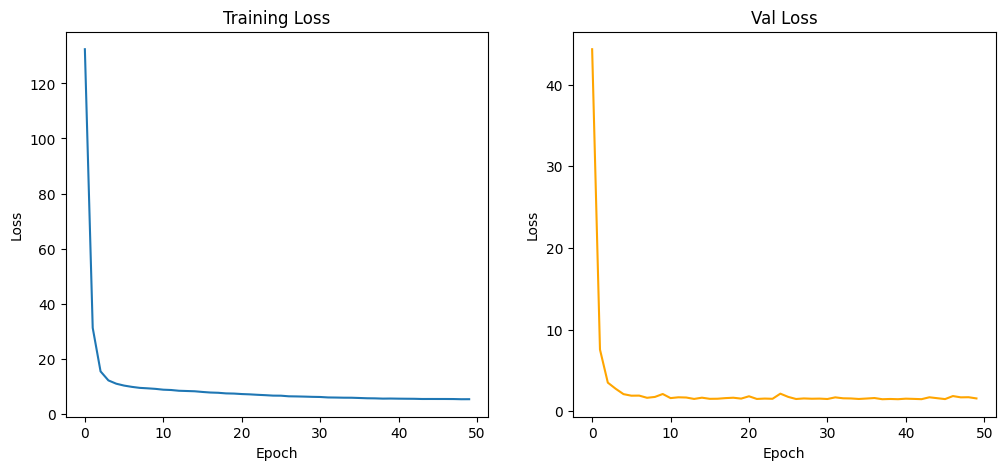

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# 10.Đánh giá mô hình
Sử dụng hàm evaluate() để đánh giá mô hình đã huấn luyện trên tập val và test như sau

In [30]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print('Evaluation on val / test dataset')
print('Val loss:', val_loss)
print('Test loss:', test_loss)

Evaluation on val / test dataset
Val loss: (1.5630547728170958, 0.005391394504924832)
Test loss: (1.378764898357797, 0.006639692914202718)


Bên cạnh đó, đối với bài toán time series, ta cũng có thể plot dự đoán của mô hình so vớidữ liệu thực tế tromg một khoảng thời gian như sau:

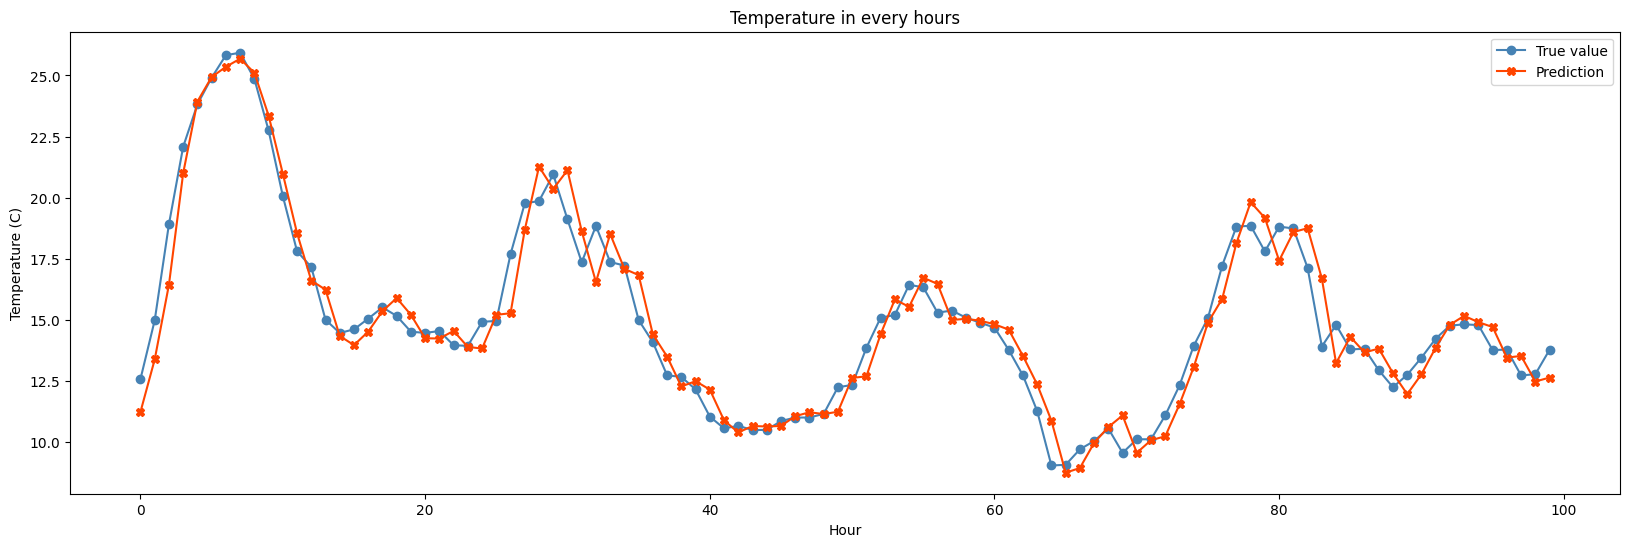

In [31]:
def plot_difference(y, pred):
  plt.figure(figsize=(20, 6))
  times = range(len(y))
  y_to_plot = y.flatten()
  pred_to_plot = pred.flatten()

  plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
  plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

  plt.title('Temperature in every hours')
  plt.xlabel('Hour')
  plt.ylabel('Temperature (C)')
  plt.legend()
  plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
  outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)